In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.set_float32_matmul_precision('high')

# Define the grid

In [41]:
def showGrid(grid):
    arr = np.ones((grid.shape[0], grid.shape[1], 3)) * 0.2
    arr[0, 5, 1] = 1
    arr[2, 0, 1] = 1
    arr[5, 5, 0] = 1
    arr[grid == 0] = 1
    plt.imshow(arr)
    plt.axis('off')
    plt.show()
    return arr

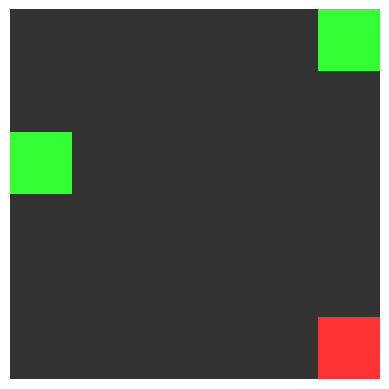

In [42]:
grid = np.ones((6, 6)) * -1
grid[0,5] = 10
grid[2,0] = 4
grid[5,5] = -5

action_vectors = torch.tensor(np.eye(4), dtype=torch.float32)
action_space = {
    0: 'Up',
    1 : 'Left',
    2 : 'Down',
    3 : 'Right'
}
_ = showGrid(grid)

# Helper Functions

In [43]:
def get_random_position():
    x = np.random.randint(low=0, high=6)
    y = np.random.randint(low=0, high=6)
    while((x,y) == (0,5) or (x,y) == (2,0) or (x,y) == (5,5)):
        x = np.random.randint(low=0, high=6)
        y = np.random.randint(low=0, high=6)
    start_grid = grid.copy()
    start_grid[x,y] = 0
    return start_grid, x, y

def next_state(curr_state, action):
    x,y = curr_state
    done = False
    if(action == action_vectors[0]).all():
        x -= 1
    elif(action == action_vectors[1]).all():
        y -= 1
    elif(action == action_vectors[2]).all():
        x += 1
    elif(action == action_vectors[3]).all():
        y += 1
    if x < 0:
        x = 0
    if x > 5:
        x = 5
    if y < 0:
        y = 0
    if y > 5:
        y = 5
    if((x, y) == (0, 5) or (x, y) == (2, 0) or (x, y) == (5, 5)):
        done = True
    grid_copy = grid.copy()
    grid_copy[int(x), int(y)] = 0
    s = torch.tensor(grid_copy, dtype=torch.float32)
    return s, x, y, done

Positions = []
for x in range(6):
    for y in range(6):
        if(x, y) != (0, 5) and (x, y) != (2, 0) and (x, y) != (5, 5):
            Positions.append((x, y))

# Define Model

In [5]:
class ValuePredictor(nn.Module):
    def __init__(self, grid_dim, action_dim):
        super(ValuePredictor, self).__init__()

        self.grid_dim = grid_dim
        self.action_dim = action_dim
        self.input_dim = (grid_dim + action_dim)

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.input_dim, out_features=128, bias=True),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=128, bias=True),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=1, bias=True)
        )
    def forward(self, x):
        return self.fc(x)

In [27]:
Q_Network = ValuePredictor(grid_dim=6*6, action_dim=4)
Q_Network = torch.compile(Q_Network).to('cuda')
optimiser = optim.AdamW(params=Q_Network.parameters(), lr=1e-4)
criterion = nn.MSELoss()

epsilon = 0.5
epsilon_decay_rate = 0.99
gamma = 0.9

num_episodes = 150
T = 15
action_vectors = action_vectors.to('cuda')

# Training

In [28]:
Losses = []
Cumulative_Rewards = []

for episode in tqdm(range(num_episodes)):
    per_episode_loss = 0.0
    per_epsisode_reward = 0.0
    for position in Positions:
        x, y = position
        initial_state = grid.copy()
        initial_state[x, y] = 0
        s = torch.tensor(initial_state, dtype=torch.float32, device='cuda').view(-1)
        
        optimiser.zero_grad()

        for t in range(T):
            prob = np.random.random()
            if prob < epsilon:
                a = action_vectors[torch.randint(low=0, high=4, size=(1,))].view(-1)
            else:
                s_a = s.unsqueeze(0).repeat(4, 1)
                s_a = torch.cat((s_a, action_vectors), dim=1)
                with torch.no_grad():
                    a = action_vectors[torch.argmax(F.softmax(Q_Network(s_a), dim=0))]
            s_next, x, y, done = next_state(curr_state=(x, y), action=a)
            s_next = s_next.view(-1).to('cuda')

            reward = grid[int(x), int(y)]
            if done:
                label = reward
            else:
                with torch.no_grad():
                    s_next_a = s_next.unsqueeze(0).repeat(4, 1).to('cuda')
                    s_next_a = torch.cat((s_next_a, action_vectors), dim=1)
                    value = torch.max(F.softmax(Q_Network(s_next_a), dim=0))
                label = reward + gamma * value
            
            s_a = torch.cat((s, a), dim=0)
            output = Q_Network(s_a)
            label = torch.tensor([label], dtype=torch.float32, device='cuda')
            loss = criterion(output, label)
            per_episode_loss += loss.item()
            loss.backward()
            s = s_next
            per_epsisode_reward += reward
            if done:
                break
        optimiser.step()
    Losses.append(per_episode_loss)
    Cumulative_Rewards.append(per_epsisode_reward)
    epsilon *= epsilon_decay_rate

100%|██████████| 150/150 [01:51<00:00,  1.35it/s]


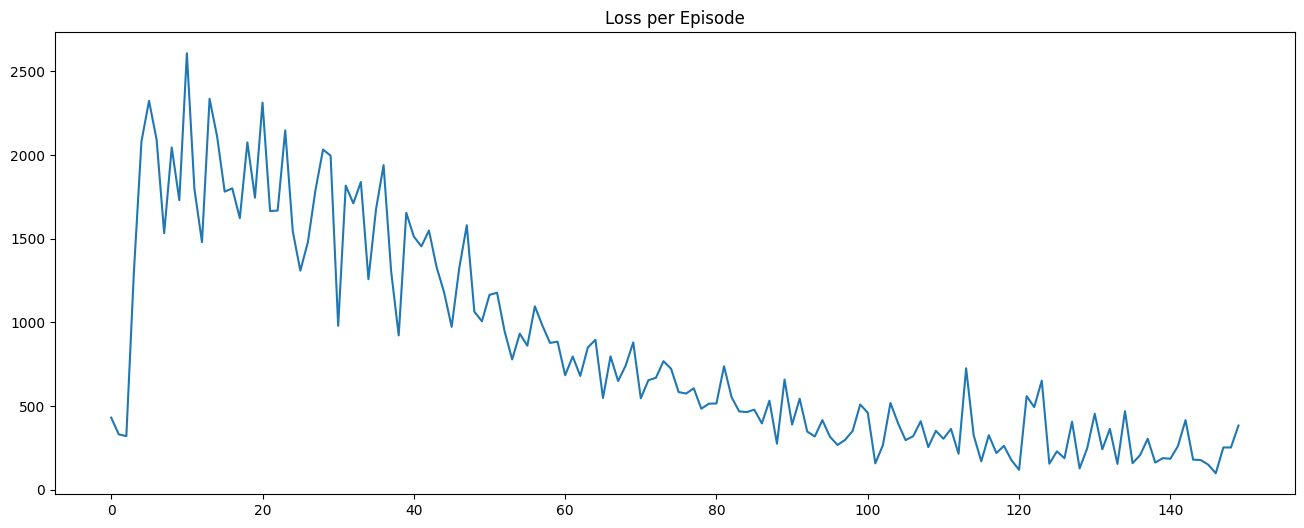

In [33]:
plt.figure(figsize=(16, 6))
plt.title("Loss per Episode")
plt.plot(Losses)
plt.show()

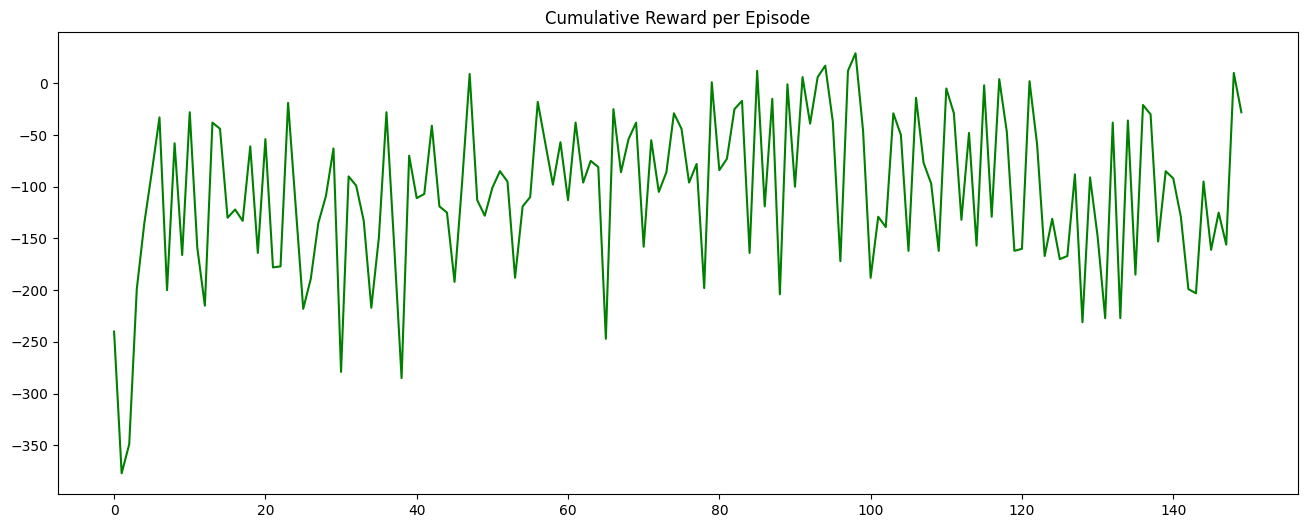

In [34]:
plt.figure(figsize = (16, 6))
plt.title("Cumulative Reward per Episode")
plt.plot(Cumulative_Rewards, color='g')
plt.show()

# Check Performance

In [35]:
board, x, y = get_random_position()
action_vectors = action_vectors.to('cuda')
Boards = [board]
done = False
steps = 0
while not done and steps < 20:
    s = torch.tensor(board, dtype=torch.float32, device='cuda').view(-1)
    s_a = s.unsqueeze(0).repeat(4, 1)
    s_a = torch.cat((s_a, action_vectors), dim=1)
    with torch.no_grad():
        a = action_vectors[torch.argmax(F.softmax(Q_Network(s_a), dim=0))]
    s_next, x, y, done = next_state(curr_state=(x, y), action=a)
    s = s_next.view(-1).to('cuda')
    board = s_next.numpy()
    Boards.append(board)
    steps += 1

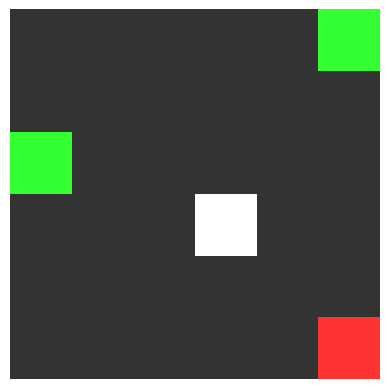

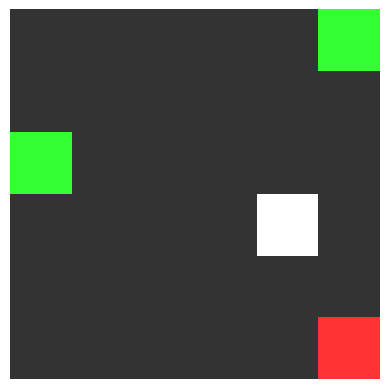

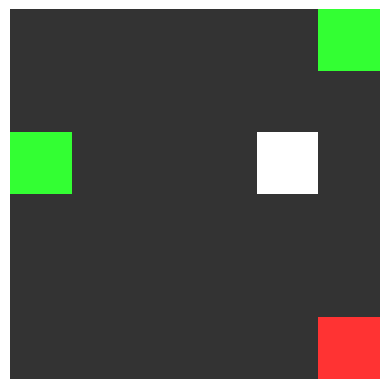

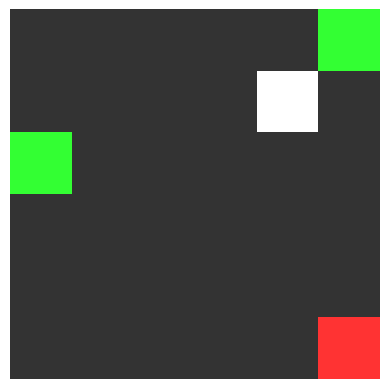

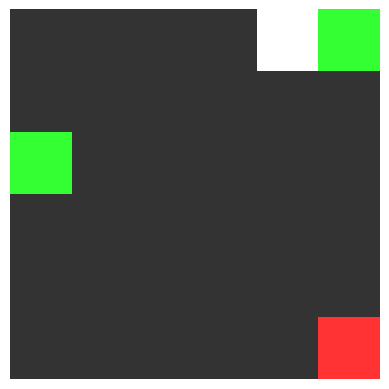

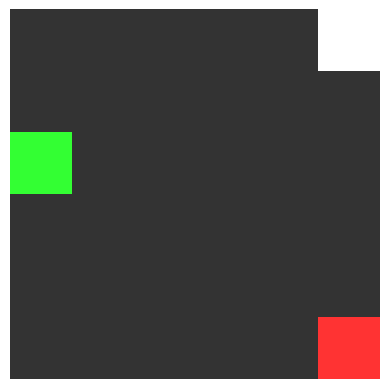

In [40]:
for board in Boards:
   _ = showGrid(board)